In [142]:
import PIL
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import glob
import numpy as np
from tensorflow.keras.layers.experimental import preprocessing


In [194]:
data_directory = r"../data/Lung-Cancer-Images/train"

In [195]:
batch_size = 13
image_height = 64
image_width = 64

In [196]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_directory,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(image_height, image_width),
  batch_size=batch_size)

Found 1578 files belonging to 2 classes.
Using 1263 files for training.


In [197]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_directory,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(image_height, image_width),
  batch_size=batch_size)

Found 1578 files belonging to 2 classes.
Using 315 files for validation.


In [198]:
class_names = train_ds.class_names
class_names

['adenocarcinoma', 'normal']

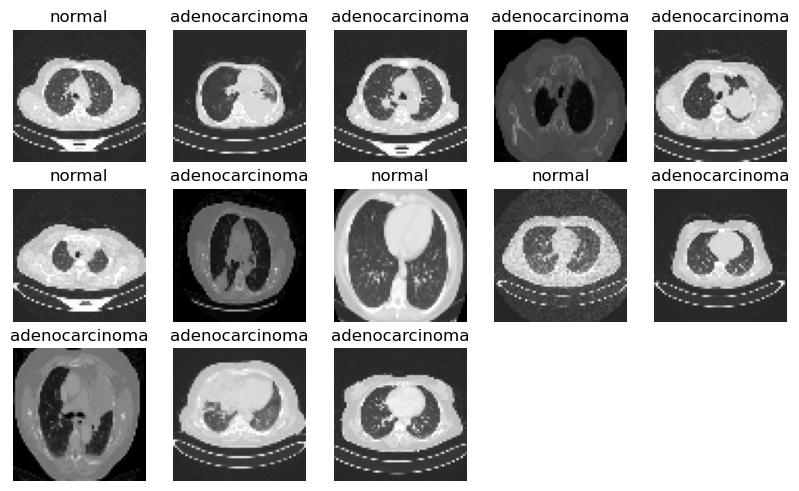

In [199]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(13):
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"),)
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [200]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(13, 64, 64, 3)
(13,)


In [201]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [208]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(260, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [209]:
model.summary()

Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_81 (Conv2D)          (None, 62, 62, 16)        448       
                                                                 
 max_pooling2d_81 (MaxPooli  (None, 31, 31, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_82 (Conv2D)          (None, 29, 29, 32)        4640      
                                                                 
 max_pooling2d_82 (MaxPooli  (None, 14, 14, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_83 (Conv2D)          (None, 12, 12, 64)        18496     
                                                                 
 max_pooling2d_83 (MaxPooli  (None, 6, 6, 64)        

In [210]:
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras.optimizers import Adam

model_optimizer = Adam(learning_rate=0.01)
model.compile(optimizer=model_optimizer,
             loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy']
             )

In [211]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=8,
    restore_best_weights=True
)

epochs = 50
history = model.fit(train_ds,
                   validation_data=val_ds,
                   epochs=epochs,
                   callbacks=early_stopping,
                   )

Epoch 1/50
98/98 [==============================] - 1s 8ms/step - loss: 18.1844 - accuracy: 0.6548 - val_loss: 0.6464 - val_accuracy: 0.7365
Epoch 2/50
98/98 [==============================] - 1s 7ms/step - loss: 0.3621 - accuracy: 0.8195 - val_loss: 0.3606 - val_accuracy: 0.8952
Epoch 3/50
98/98 [==============================] - 1s 7ms/step - loss: 0.3018 - accuracy: 0.8836 - val_loss: 0.4304 - val_accuracy: 0.8381
Epoch 4/50
98/98 [==============================] - 1s 7ms/step - loss: 0.1683 - accuracy: 0.9319 - val_loss: 0.3183 - val_accuracy: 0.9143
Epoch 5/50
98/98 [==============================] - 1s 12ms/step - loss: 0.2243 - accuracy: 0.9145 - val_loss: 0.2841 - val_accuracy: 0.9079
Epoch 6/50
98/98 [==============================] - 1s 15ms/step - loss: 0.1093 - accuracy: 0.9517 - val_loss: 0.2394 - val_accuracy: 0.9365
Epoch 7/50
98/98 [==============================] - 1s 13ms/step - loss: 0.1725 - accuracy: 0.9446 - val_loss: 0.2658 - val_accuracy: 0.9302
Epoch 8/50
98/98

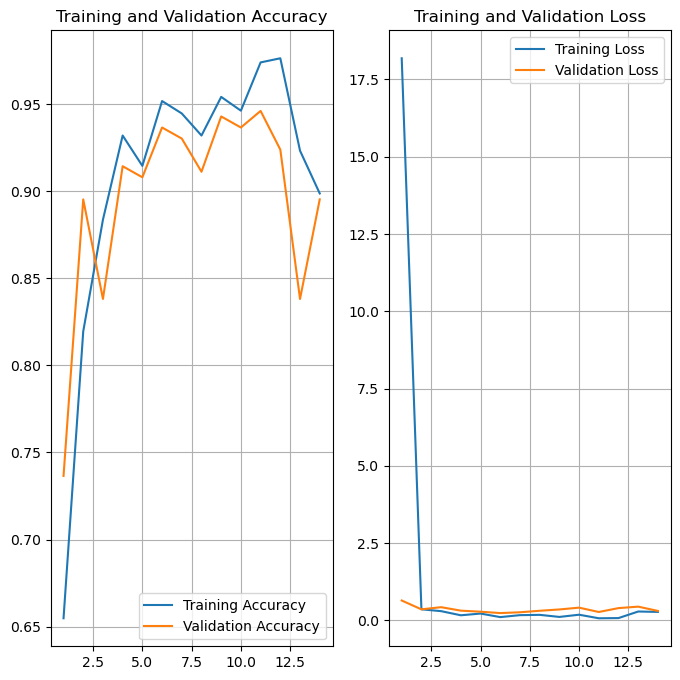

In [212]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(1, len(acc) + 1)  

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.grid()
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.grid()
plt.title('Training and Validation Loss')
plt.show()

In [270]:
image_path = r"../test/normal_test/6 - Copy (3).png"
img = tf.keras.utils.load_img(
    image_path, target_size=(image_height, image_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) 

predictions = model.predict(img_array)
score = tf.nn.sigmoid(predictions[0])

print(
    "This image most likely belongs to {}".format(class_names[np.argmax(score)])
)

1/1 [==============================] - 0s 17ms/step
This image most likely belongs to adenocarcinoma


In [279]:
model.save("saved_model")

INFO:tensorflow:Assets written to: saved_model\assets


INFO:tensorflow:Assets written to: saved_model\assets


In [280]:
from tensorflow.keras.models import load_model
loaded_model = load_model("saved_model")